# Intro

## Data Explanation
I decided to use the behavioral dataset from the Human Connectome Project (HCP), which includes demographic information, behavioral data and measures of brain structure/function for 1206 young participants (ages 22-35).

The HCP data is open-access: the reference manual can be found [here](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf) and the data can be found [here](http://db.humanconnectome.org/) if you're interested. You will need to register an account to access the data, but that process should be straightforward.

## Replication Notes
I downloaded the data on my google drive [here](https://drive.google.com/file/d/1-F5s908KDLcbfDlN1BYOBWKhe1E4tqWC/view?usp=sharing ), so to replicate the results of this notebook, follow the above link and download the `HCP-behavioral.csv` file to your own Google Drive. Just make sure when reading the file (in the first code cell below) that the path is correct. I put my file in a folder called `Data`, but you can put yours wherever, as long as the path argument for the `read_csv()` function is specific to the location of your version of `HCP-behavioral.csv`.

## Analysis Plan and Hypothesis
I decided to perform an one-way between subjects ANOVA to examine the effect of brain structure on a working memory task. In particular, I wanted to see if the cortical surface area of the left frontal pole would be associated with mean differences in accuracy of the working memory task. This would sort of be a replication study for this paper: [Cortical surface area of the left frontal pole is associated with visuospatial working memory capacity](https://pubmed.ncbi.nlm.nih.gov/32437760/).

Therefore, my $H_0$ would be that there are no differences in the accuracies for each surface area category, and my $H_1$ is that as surface area increases, accuracy for the working memory task will increase. 

If there are significant results, I will run a Tukey HSD test to examine which comparisons were significant.

![picture](https://prod-images-static.radiopaedia.org/images/24313068/eb64f82d9a45f974aedf3262cd2c07_jumbo.jpeg)

# Data Preparation

## Importing Libraries, Mounting Gdrive, Loading Data
First, proper library/module imports must be done. Additionally, because I intend to analyze the data in Colab and have the HCP data on my Google Drive, I will mount my Google Drive onto the Google Colab runtime. See [here](https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166) for a guide.  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf # for the OLS module
import statsmodels.stats.multicomp as multi # for multiple comparisons test

# Mounting Google Drive onto Colab
import google.colab.drive as drive 
drive.mount('/content/gdrive')

# Reading the file
data = pd.read_csv('/content/gdrive/MyDrive/Data/HCP-behavioral.csv', low_memory=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# getting a feel for the structure of the dataset
data

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,3T_tMRI_PctCompl,fMRI_WM_PctCompl,fMRI_Gamb_PctCompl,fMRI_Mot_PctCompl,fMRI_Lang_PctCompl,fMRI_Soc_PctCompl,fMRI_Rel_PctCompl,fMRI_Emo_PctCompl,3T_dMRI_Compl,3T_dMRI_PctCompl,dMRI_3T_ReconVrs,fMRI_3T_ReconVrs,7T_Full_MR_Compl,7T_RS-fMRI_Count,7T_RS-fMRI_PctCompl,7T_Full_Task_fMRI,7T_tMRI_PctCompl,fMRI_Movie_Compl,fMRI_Movie_PctCompl,fMRI_Ret_Compl,fMRI_Ret_PctCompl,7T_dMRI_Compl,7T_dMRI_PctCompl,7T_fMRI_Mov_Vrs,MEG_AnyData,MEG_FullProt_Compl,MEG_HeadModel_Avail,MEG_CortRibn_Avail,MEG_Anatomy_Avail,...,NEORAW_31,NEORAW_32,NEORAW_33,NEORAW_34,NEORAW_35,NEORAW_36,NEORAW_37,NEORAW_38,NEORAW_39,NEORAW_40,NEORAW_41,NEORAW_42,NEORAW_43,NEORAW_44,NEORAW_45,NEORAW_46,NEORAW_47,NEORAW_48,NEORAW_49,NEORAW_50,NEORAW_51,NEORAW_52,NEORAW_53,NEORAW_54,NEORAW_55,NEORAW_56,NEORAW_57,NEORAW_58,NEORAW_59,NEORAW_60,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,NaN,NaN,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,D,D,N,A,SA,N,N,A,A,A,D,N,D,A,A,N,A,SA,A,A,N,A,A,A,A,D,N,N,D,A,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r227,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,N,N,D,A,A,N,A,N,D,N,N,D,D,A,A,N,N,N,A,N,N,A,A,D,N,D,N,D,A,N,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r177,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,True,False,True,True,True,...,A,A,D,A,A,SD,A,N,D,A,D,D,N,D,D,A,A,D,A,A,D,SA,A,SD,D,D,D,D,SD,A,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r177,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,A,D,D,A,A,SD,A,SD,D,A,D,N,D,N,D,N,A,D,SA,A,D,A,A,N,D,N,D,A,A,A,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r227,True,4,100.0,True,100.0,True,100.0,True,100.0,True,100.0,2.0,False,False,False,False,False,...,SA,D,D,A,A,SD,D,N,A,A,SD,N,A,A,D,A,D,D,SA,A,SD,N,SA,SD,D,A,SA,SA,D,A,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,992774,Q2,Q02,M,31-35,True,2,2,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r177,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,A,D,N,SA,A,D,A,A,D,A,D,D,N,N,SD,SD,A,D,SA,SA,D,SA,A,D,D,SD,SD,A,SD,SA,8.4,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76
1202,993675,S900,Q09,F,26-30,True,2,2,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r227,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,A,D,SD,A,A,D,N,A,SD,SA,D,D,A,SD,A,A,D,SD,SA,SA,D,N,A,D,D,SD,D,D,SD,SA,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76
1203,994273,S500,Q06,M,26-30,True,1,1,4,100.0,True,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,True,100.0,r227,r227,False,0,0.0,False,0.0,False,0.0,False,0.0,False,0.0,NaN,False,False,False,False,False,...,D,A,D,A,SA,N,N,SD,N,A,D,N,N,A,N,N,A,D,A,A,D,A,A,N,N,D,N,N,N,A,6.0,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76
1204,995174,S

## Converting from Continuous IV to Categorical IV
I first needed to turn the continous variable of surface area into a categorical variable, so I thought maybe separating surface area measurements into quartiles would work: https://towardsdatascience.com/what-are-quartiles-c3e117114cf1

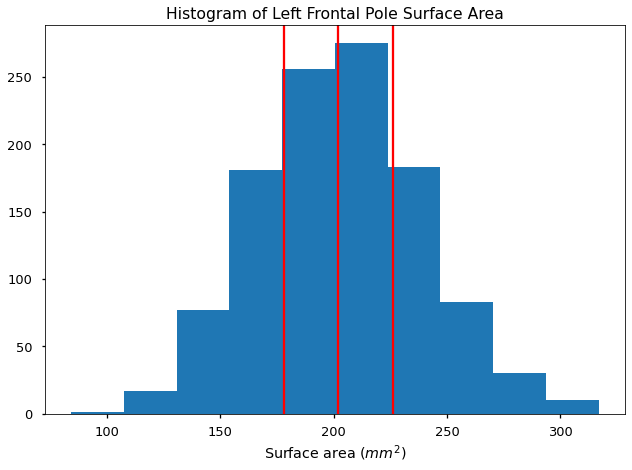

Quartiles are: 
25%tile: 178.0mm, 50%tile: 202.0mm, 75%tile: 226.0mm


In [ ]:
# Define quartiles
L_FP_SA = data['FS_L_Frontalpole_Area'].dropna()
quartiles = np.quantile(L_FP_SA, .25), np.quantile(L_FP_SA, .50), np.quantile(L_FP_SA, .75)

# look at the distribution
plt.style.use('seaborn-talk')
plt.hist(L_FP_SA)
for i in quartiles:
  plt.axvline(i, color='r')
plt.xlabel('Surface area ($mm^2$)')
plt.title('Histogram of Left Frontal Pole Surface Area')
plt.show()
print(f'Quartiles are: \n25%tile: {quartiles[0]}mm, 50%tile: {quartiles[1]}mm, 75%tile: {quartiles[2]}mm'.format(quartiles))

Conditional column creation: https://www.delftstack.com/howto/python-pandas/how-to-create-dataframe-column-based-on-given-condition-in-pandas/

In [ ]:
# np.select requires a list for your selection conditions and a list for your choice conditions
# the indices should be matched for both the selection and choice conditions
conditionlist = [
                 (data['FS_L_Frontalpole_Area'] < quartiles[0]),
                 (data['FS_L_Frontalpole_Area'] >= quartiles[0]) & (data['FS_L_Frontalpole_Area'] < quartiles[1]),
                 (data['FS_L_Frontalpole_Area'] >= quartiles[1]) & (data['FS_L_Frontalpole_Area'] < quartiles[2]),
                 (data['FS_L_Frontalpole_Area'] >= quartiles[2]),
]
choicelist = ['1st', '2nd', '3rd', '4th']

data['FS_L_Frontalpole_Area_Quartile'] = np.select(conditionlist, choicelist, default=None)

## Subsetting the Data

In [ ]:
# I've included the continuous surface area variable as well to double check that the quartile conversion was correct
leftFP_WM_df = data[['FS_L_Frontalpole_Area', 'FS_L_Frontalpole_Area_Quartile', 'WM_Task_Acc']]
leftFP_WM_df_ = leftFP_WM_df.dropna()
leftFP_WM_df_

,FS_L_Frontalpole_Area,FS_L_Frontalpole_Area_Quartile,WM_Task_Acc
1,298.0,4th,91.596
2,185.0,2nd,85.425
3,273.0,4th,91.138
4,206.0,3rd,96.867
5,151.0,1st,73.017
...,...,...,...
1201,144.0,1st,91.179
1202,185.0,2nd,93.167
1203,150.0,1st,80.783
1204,192.0,2nd,88.687


# Analysis

## ANOVA Table

In [ ]:
model1= smf.ols(formula='WM_Task_Acc ~ C(FS_L_Frontalpole_Area_Quartile)', data=leftFP_WM_df_)
print(model1.fit().summary())

                            OLS Regression Results                            
Dep. Variable:            WM_Task_Acc   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     5.045
Date:                Thu, 16 Sep 2021   Prob (F-statistic):            0.00178
Time:                        20:22:36   Log-Likelihood:                -3979.9
No. Observations:                1091   AIC:                             7968.
Df Residuals:                    1087   BIC:                             7988.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

## Group Means

In [ ]:
leftFP_WM_df_means = leftFP_WM_df_.groupby('FS_L_Frontalpole_Area_Quartile').mean()
print(leftFP_WM_df_means)
leftFP_WM_df_stds = leftFP_WM_df_.groupby('FS_L_Frontalpole_Area_Quartile').std()
print(leftFP_WM_df_.groupby('FS_L_Frontalpole_Area_Quartile').std())

                                FS_L_Frontalpole_Area  WM_Task_Acc
FS_L_Frontalpole_Area_Quartile                                    
1st                                        158.105263    85.123387
2nd                                        189.642586    86.118087
3rd                                        212.531690    87.427049
4th                                        248.525180    87.916835
                                FS_L_Frontalpole_Area  WM_Task_Acc
FS_L_Frontalpole_Area_Quartile                                    
1st                                         15.390643     9.459680
2nd                                          7.057129     9.292525
3rd                                          7.010017     8.894132
4th                                         19.321461     9.585850


Bar plotting: https://benalexkeen.com/bar-charts-in-matplotlib/

In [ ]:
# defining variables for bar plot
x = list(leftFP_WM_df_means.index)
x_pos = [i for i, _ in enumerate(x)]
y = leftFP_WM_df_means.values[:, 1]
yerr = leftFP_WM_df_stds.values[:, 1] # error of y
print(x_pos, x, y, yerr, sep='\n')

[0, 1, 2, 3]
['1st', '2nd', '3rd', '4th']
[85.12338722 86.11808745 87.4270493  87.91683453]
[9.45968021 9.29252526 8.89413186 9.58584982]


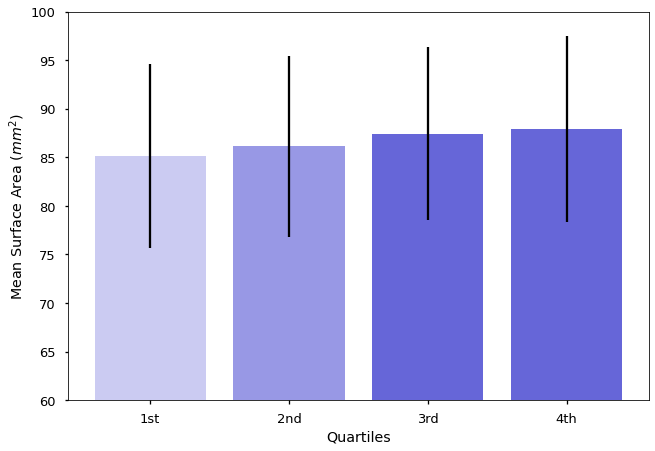

In [ ]:
plt.style.use('seaborn-talk')
plt.bar(x=x_pos, height=y, yerr=yerr, color=[(0.2, 0.2, 0.8, 0.25), (0.2, 0.2, 0.8, 0.50), (0.2, 0.2, 0.8, 0.75), (0.2, 0.2, 0.8, 0.75)])
plt.xticks(x_pos, x)
plt.ylim(60, 100)
plt.xlabel('Quartiles')
plt.ylabel('Mean Surface Area ($mm^2$)')
plt.show()

## Multiple Comparisons

In [ ]:
mc1 = multi.MultiComparison(leftFP_WM_df_['WM_Task_Acc'], leftFP_WM_df_['FS_L_Frontalpole_Area_Quartile'])
print(mc1.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd   0.9947 0.5955 -1.0879 3.0773  False
   1st    3rd   2.3037 0.0198  0.2601 4.3472   True
   1st    4th   2.7934 0.0027  0.7393 4.8476   True
   2nd    3rd    1.309 0.3553 -0.7406 3.3585  False
   2nd    4th   1.7987 0.1117 -0.2614 3.8589  False
   3rd    4th   0.4898    0.9 -1.5309 2.5104  False
---------------------------------------------------


# Write-Up

## APA Style
A one-way between subjects ANOVA was conducted to compare the effect of left frontal pole surface area (mm) on mean accuracy (% correct) of a working memory n-back task. Left frontal pole surface area was separated into low, medium-low, medium-high, and high conditions (quartiles). 

Results showed a significant effect of left frontal pole surface area on mean accuracy of a working memory n-back task at the p<.05 level for the four conditions [F(3, 1087) = 5.045, p = 0.002]. 

Post hoc comparisons using the Tukey HSD test indicated that the mean accuracy for the low condition (M = 85.12, SD = 9.49) was significantly different than the medium-high (M = 87.43, SD = 8.89) and high conditions (M = 87.91, SD = 9.59). However, the low-medium condition (M = 86.12, SD = 9.29) was not significantly different from any other condition, and neither was the comparison between the high-medium and high conditions.

## Plain English
I saw a relatively recent neuroscience paper suggesting that a frontal region of the brain was associated with working memory performance, which is important for many tasks, and the capacity of which is predictive of things like IQ. 

I wanted to see if I could replicate those recent results so I downloaded data from the Human Connectome Project (which is separate from the recent paper) and ran a statistical test, the results of which indeed suggested that as the surface area of this brain area increases, working memory performance increases as well. 

## Discussion
Further questions:
1. **Do other regions have similar associations?:** The HCP dataset includes 34 areas on each hemisphere of the brain that have surface area measurements, as well as additional measurements for cortical thickness and volume, so further analysis with this method could easily be scripted.
2. **Is this region specific for working memory?:** Because working memory is a higher-order function, it would be unsurprising to see this region associated with other cognitive functions.
3. **Is this a causal relationship?:** Maybe a TMS study could help determine whether this region is necessary for working memory